<a href="https://colab.research.google.com/github/Dor-Nachbi/DCGAN_LSGAN/blob/master/This_Fish_Doesn't_Exist_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#We've compressed the processed images to .pkl file in order to save the long loading time.
#The compressed file can be found here https://drive.google.com/file/d/1UQ1f8PQfL3v6Hm1leT2JNPEXiKHrc9_b/view?usp=sharing

from __future__ import absolute_import, division, print_function, unicode_literals
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Model, Input
from google.colab import drive
import matplotlib.pyplot as plt
import pickle
import numpy as np
import time
import os

tf.__version__


'2.2.0-rc2'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
there are  4457 images
load time is: 67.84407234191895
data loaded, shuffled and split to 140 batches
(140, 320, 3)


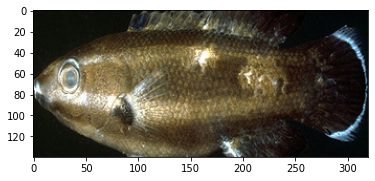

In [0]:
drive.mount('/content/drive/')

BATCH_SIZE = 32
IMG_HEIGHT = 140
IMG_WIDTH = 320
IMG_CHANNELS = 3
NOISE_SIZE = 512
EPOCHS = 1000
images_path = '/content/drive/My Drive/resize/images.pkl'
output_directory = '/content/drive/My Drive/images'
sample_imgs_path = output_directory + '/generated_images'
graph_path = output_directory + '/loss_graphs'
models_save_path = output_directory + '/models'
disc_save_name = '/discriminator.h5'
gen_save_name = '/generator.h5'
conv_time = time.time()

# the fish images normalized between 1 and -1
with open(images_path, 'rb') as input:
    images = pickle.load(input)

n_images = len(images)

print('there are ', n_images, 'images')
print('load time is: {}'.format(time.time() - conv_time))

dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(n_images).batch(BATCH_SIZE)

n_batch = int(np.ceil(n_images / BATCH_SIZE))

print('data loaded, shuffled and split to {} batches'.format(n_batch))

sample = next(dataset.as_numpy_iterator())[0]
print(sample.shape)
plt.imshow((sample + 1) / 2)
plt.show()


**Optimizers & Params**

In [0]:
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)


@tf.function
def discriminator_loss(D_x, D_Gz):
    valid = tf.ones_like(D_x)
    fake = tf.zeros_like(D_Gz)
    valid = noisy_labels(valid, 0.05)
    fake = noisy_labels(fake, 0.05)
    valid = smooth_positive_labels(valid)
    fake = smooth_negative_labels(fake)
    L_Dx = cross_entropy(valid, D_x)
    L_D_Gz = cross_entropy(fake, D_Gz)
    return L_Dx, L_D_Gz


@tf.function
def generator_loss(D_Gz):
    return -tf.keras.backend.log(D_Gz)


# Gaussian Weight Initialization
init_disc = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)
init_gen = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)


**The Discriminator**

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer=init_disc, input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,
                            kernel_initializer=init_disc))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,
                            kernel_initializer=init_disc))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,
                            kernel_initializer=init_disc))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    model._name = 'discriminator'
    model.summary()
    return model


**Create Discriminator**

In [0]:
if os.path.exists(models_save_path + disc_save_name):
    discriminator = load_model(models_save_path + disc_save_name, custom_objects={'LeakyReLU': layers.LeakyReLU(0.2)}, compile=False)
    print("Loaded discriminator...")
else:
    discriminator = make_discriminator_model()
    print("Generated discriminator")

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 140, 320, 32)      2400      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 140, 320, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 160, 64)       51200     
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 160, 64)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 70, 160, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 80, 128)       204800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 80, 128)     

**The Generator**

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 16 * 512, use_bias=False, input_shape=(NOISE_SIZE,)))

    model.add(layers.Reshape((7, 16, 512)))
    assert model.output_shape == (None, 7, 16, 512)

    model.add(layers.Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False,
                                     kernel_initializer=init_gen))
    assert model.output_shape == (None, 7, 16, 256)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,
                                     kernel_initializer=init_gen))
    assert model.output_shape == (None, 14, 32, 128)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,
                                     kernel_initializer=init_gen))
    assert model.output_shape == (None, 28, 64, 64)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(filters=16, kernel_size=(7, 7), strides=(5, 5), padding='same', use_bias=False,
                                     kernel_initializer=init_gen))
    assert model.output_shape == (None, 140, 320, 16)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(3, kernel_initializer=init_gen, activation='tanh'))
    assert model.output_shape == (None, 140, 320, 3)

    model._name = 'generator'
    model.summary()
    return model

**Create Generator**

In [0]:
if os.path.exists(models_save_path + gen_save_name):
    generator = load_model(models_save_path + gen_save_name, custom_objects={'LeakyReLU': layers.LeakyReLU(0.2)}, compile=False)
    print("Loaded generator...")
else:
    generator = make_generator_model()
    print("Generated generator")


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 57344)             29360128  
_________________________________________________________________
reshape (Reshape)            (None, 7, 16, 512)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 16, 256)        3276800   
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 16, 256)        1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 16, 256)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 16, 256)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 32, 128)       81

**Train Functions**

In [0]:
@tf.function
def train_step(X):
    batch_size = X.shape[0]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # ----- Train Discriminator -----
        z = tf.random.normal([batch_size, NOISE_SIZE])
        Gz = generator(z, training=True)

        D_x = discriminator(X, training=True)
        D_Gz = discriminator(Gz, training=True)
        d_x_loss, d_gz_loss = discriminator_loss(D_x=D_x, D_Gz=D_Gz)
        gradients_of_discriminator = disc_tape.gradient(d_x_loss + d_gz_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # ----- Train Generator -----
        z = tf.random.normal([batch_size, NOISE_SIZE])
        Gz = generator(z, training=True)
        D_Gz = discriminator(Gz, training=True)
        g_loss = generator_loss(D_Gz)
        gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return d_x_loss, d_gz_loss, g_loss

# # Label Smoothing
def smooth_positive_labels(y):
    return y - 0.2 + (np.random.random(y.shape) * 0.2)


def smooth_negative_labels(y):
    return y + (np.random.random(y.shape) * 0.3)


# randomly flip some labels
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * int(y.shape[0]))
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)

    op_list = []
    # invert the labels in place
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(1 - y[i])
        else:
            op_list.append(y[i])

    outputs = tf.stack(op_list)
    return outputs


def generate_noise(n_samples, n_size):
    x = np.random.randn(n_samples * n_size)
    return np.reshape(x, (n_samples, n_size))


**Train**

start epoch 1
epoch: 1 [D real loss: 0.979635] [D fake loss: 1.917479] [D mean loss: 1.448557] [G loss: 8.684924]
Time for epoch 1 is 85.71869492530823 sec
start epoch 2
epoch: 2 [D real loss: 0.696057] [D fake loss: 1.166512] [D mean loss: 0.931284] [G loss: 4.983211]
Time for epoch 2 is 77.11534023284912 sec
start epoch 3
epoch: 3 [D real loss: 0.497652] [D fake loss: 0.619859] [D mean loss: 0.558755] [G loss: 2.109014]
Time for epoch 3 is 78.00506019592285 sec
start epoch 4
epoch: 4 [D real loss: 0.465427] [D fake loss: 0.556508] [D mean loss: 0.510967] [G loss: 1.853295]
Time for epoch 4 is 77.81017827987671 sec
start epoch 5
epoch: 5 [D real loss: 0.478162] [D fake loss: 0.568704] [D mean loss: 0.523433] [G loss: 1.897268]
Time for epoch 5 is 77.9363489151001 sec
start epoch 6
epoch: 6 [D real loss: 0.484915] [D fake loss: 0.550903] [D mean loss: 0.517909] [G loss: 1.837242]
Time for epoch 6 is 77.76182293891907 sec
start epoch 7
epoch: 7 [D real loss: 0.454983] [D fake loss: 0.54

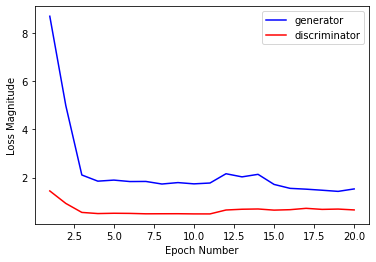

fish in epoch: 20


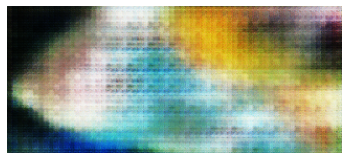

Time for epoch 20 is 83.62357831001282 sec
start epoch 21
epoch: 21 [D real loss: 0.627088] [D fake loss: 0.704261] [D mean loss: 0.665674] [G loss: 1.547483]
Time for epoch 21 is 77.93565607070923 sec
start epoch 22
epoch: 22 [D real loss: 0.599821] [D fake loss: 0.699540] [D mean loss: 0.649680] [G loss: 1.526920]
Time for epoch 22 is 77.89896488189697 sec
start epoch 23
epoch: 23 [D real loss: 0.582646] [D fake loss: 0.699623] [D mean loss: 0.641134] [G loss: 1.536111]
Time for epoch 23 is 77.6127564907074 sec
start epoch 24
epoch: 24 [D real loss: 0.604003] [D fake loss: 0.720035] [D mean loss: 0.662019] [G loss: 1.587419]
Time for epoch 24 is 77.80596208572388 sec
start epoch 25
epoch: 25 [D real loss: 0.552419] [D fake loss: 0.669759] [D mean loss: 0.611089] [G loss: 1.529751]
Time for epoch 25 is 77.66400098800659 sec
start epoch 26
epoch: 26 [D real loss: 0.560259] [D fake loss: 0.667648] [D mean loss: 0.613954] [G loss: 1.550299]
Time for epoch 26 is 77.61097145080566 sec
star

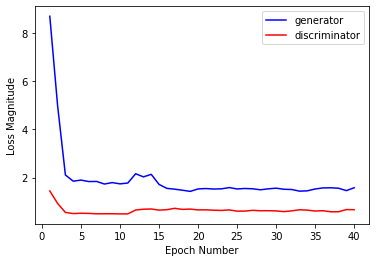

fish in epoch: 40


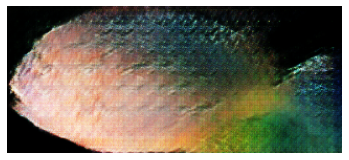

Time for epoch 40 is 81.48429703712463 sec
start epoch 41
epoch: 41 [D real loss: 0.566757] [D fake loss: 0.720032] [D mean loss: 0.643394] [G loss: 1.635605]
Time for epoch 41 is 77.50452423095703 sec
start epoch 42
epoch: 42 [D real loss: 0.532724] [D fake loss: 0.659645] [D mean loss: 0.596185] [G loss: 1.651107]
Time for epoch 42 is 77.85899996757507 sec
start epoch 43
epoch: 43 [D real loss: 0.509573] [D fake loss: 0.663174] [D mean loss: 0.586373] [G loss: 1.657489]
Time for epoch 43 is 77.83801698684692 sec
start epoch 44
epoch: 44 [D real loss: 0.539176] [D fake loss: 0.682619] [D mean loss: 0.610898] [G loss: 1.561963]
Time for epoch 44 is 77.83816456794739 sec
start epoch 45
epoch: 45 [D real loss: 0.534771] [D fake loss: 0.642841] [D mean loss: 0.588806] [G loss: 1.576037]
Time for epoch 45 is 77.63999557495117 sec
start epoch 46
epoch: 46 [D real loss: 0.536927] [D fake loss: 0.665775] [D mean loss: 0.601351] [G loss: 1.567836]
Time for epoch 46 is 77.8810818195343 sec
star

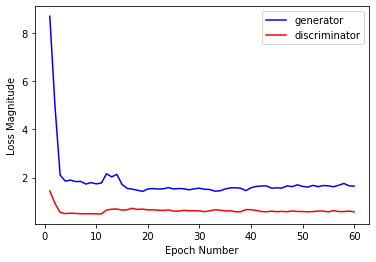

fish in epoch: 60


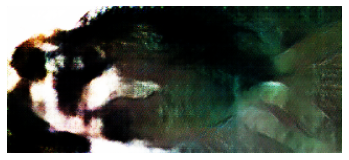

Time for epoch 60 is 82.19932866096497 sec
start epoch 61
epoch: 61 [D real loss: 0.528495] [D fake loss: 0.657977] [D mean loss: 0.593236] [G loss: 1.683033]
Time for epoch 61 is 77.55512928962708 sec
start epoch 62
epoch: 62 [D real loss: 0.530597] [D fake loss: 0.688193] [D mean loss: 0.609395] [G loss: 1.662868]
Time for epoch 62 is 77.85322952270508 sec
start epoch 63
epoch: 63 [D real loss: 0.514757] [D fake loss: 0.651336] [D mean loss: 0.583047] [G loss: 1.669214]
Time for epoch 63 is 77.64535999298096 sec
start epoch 64
epoch: 64 [D real loss: 0.514726] [D fake loss: 0.681442] [D mean loss: 0.598084] [G loss: 1.736015]
Time for epoch 64 is 77.67094683647156 sec
start epoch 65
epoch: 65 [D real loss: 0.491655] [D fake loss: 0.648579] [D mean loss: 0.570117] [G loss: 1.626764]
Time for epoch 65 is 77.90566921234131 sec
start epoch 66
epoch: 66 [D real loss: 0.519954] [D fake loss: 0.673693] [D mean loss: 0.596824] [G loss: 1.695604]
Time for epoch 66 is 77.8122022151947 sec
star

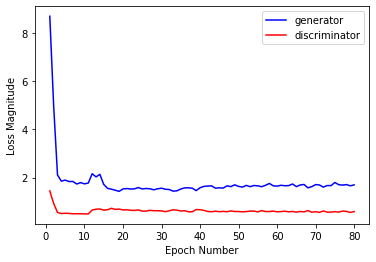

fish in epoch: 80


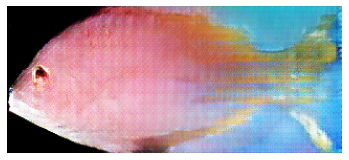

Time for epoch 80 is 81.61798214912415 sec
start epoch 81
epoch: 81 [D real loss: 0.501203] [D fake loss: 0.632091] [D mean loss: 0.566647] [G loss: 1.669888]
Time for epoch 81 is 77.81693387031555 sec
start epoch 82
epoch: 82 [D real loss: 0.526397] [D fake loss: 0.667150] [D mean loss: 0.596774] [G loss: 1.614277]
Time for epoch 82 is 77.92692160606384 sec
start epoch 83
epoch: 83 [D real loss: 0.502031] [D fake loss: 0.646148] [D mean loss: 0.574089] [G loss: 1.745448]
Time for epoch 83 is 77.82803106307983 sec
start epoch 84
epoch: 84 [D real loss: 0.496146] [D fake loss: 0.636063] [D mean loss: 0.566104] [G loss: 1.722672]
Time for epoch 84 is 77.78863072395325 sec
start epoch 85
epoch: 85 [D real loss: 0.494249] [D fake loss: 0.635393] [D mean loss: 0.564821] [G loss: 1.633701]
Time for epoch 85 is 77.85684013366699 sec
start epoch 86
epoch: 86 [D real loss: 0.504427] [D fake loss: 0.660708] [D mean loss: 0.582568] [G loss: 1.741841]
Time for epoch 86 is 77.85158371925354 sec
sta

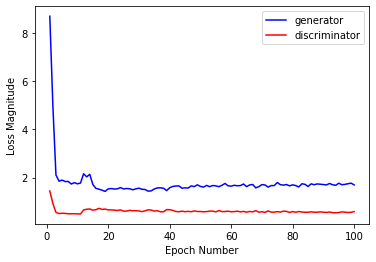

fish in epoch: 100


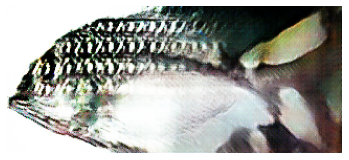

Time for epoch 100 is 81.46074414253235 sec
start epoch 101
epoch: 101 [D real loss: 0.481235] [D fake loss: 0.611812] [D mean loss: 0.546524] [G loss: 1.688314]
Time for epoch 101 is 77.53197312355042 sec
start epoch 102
epoch: 102 [D real loss: 0.478972] [D fake loss: 0.620952] [D mean loss: 0.549962] [G loss: 1.729507]
Time for epoch 102 is 77.8999993801117 sec
start epoch 103
epoch: 103 [D real loss: 0.504849] [D fake loss: 0.637435] [D mean loss: 0.571142] [G loss: 1.724494]
Time for epoch 103 is 77.80714559555054 sec
start epoch 104
epoch: 104 [D real loss: 0.474907] [D fake loss: 0.615814] [D mean loss: 0.545361] [G loss: 1.660279]
Time for epoch 104 is 77.85012006759644 sec
start epoch 105
epoch: 105 [D real loss: 0.500401] [D fake loss: 0.625939] [D mean loss: 0.563170] [G loss: 1.733012]
Time for epoch 105 is 77.76728534698486 sec
start epoch 106
epoch: 106 [D real loss: 0.509034] [D fake loss: 0.640406] [D mean loss: 0.574720] [G loss: 1.758094]
Time for epoch 106 is 77.7987

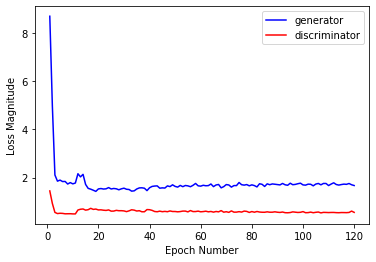

fish in epoch: 120


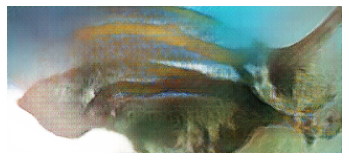

Time for epoch 120 is 82.79253244400024 sec
start epoch 121
epoch: 121 [D real loss: 0.469129] [D fake loss: 0.589719] [D mean loss: 0.529424] [G loss: 1.677611]
Time for epoch 121 is 77.52097582817078 sec
start epoch 122
epoch: 122 [D real loss: 0.468967] [D fake loss: 0.613785] [D mean loss: 0.541376] [G loss: 1.710421]
Time for epoch 122 is 77.50681900978088 sec
start epoch 123
epoch: 123 [D real loss: 0.468541] [D fake loss: 0.608638] [D mean loss: 0.538589] [G loss: 1.755764]
Time for epoch 123 is 77.45983934402466 sec
start epoch 124
epoch: 124 [D real loss: 0.479259] [D fake loss: 0.618990] [D mean loss: 0.549124] [G loss: 1.753042]
Time for epoch 124 is 77.34399318695068 sec
start epoch 125
epoch: 125 [D real loss: 0.470602] [D fake loss: 0.608959] [D mean loss: 0.539781] [G loss: 1.731172]
Time for epoch 125 is 77.38111901283264 sec
start epoch 126
epoch: 126 [D real loss: 0.491360] [D fake loss: 0.624965] [D mean loss: 0.558162] [G loss: 1.748236]
Time for epoch 126 is 77.214

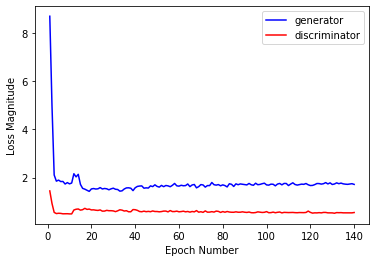

fish in epoch: 140


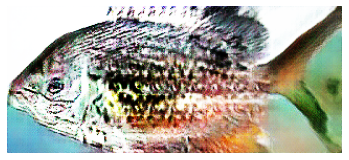

Time for epoch 140 is 81.43079161643982 sec
start epoch 141
epoch: 141 [D real loss: 0.467631] [D fake loss: 0.601427] [D mean loss: 0.534529] [G loss: 1.686772]
Time for epoch 141 is 77.09098792076111 sec
start epoch 142
epoch: 142 [D real loss: 0.460197] [D fake loss: 0.592724] [D mean loss: 0.526461] [G loss: 1.696005]
Time for epoch 142 is 77.08920550346375 sec
start epoch 143
epoch: 143 [D real loss: 0.486329] [D fake loss: 0.623840] [D mean loss: 0.555085] [G loss: 1.727459]
Time for epoch 143 is 76.9377384185791 sec
start epoch 144
epoch: 144 [D real loss: 0.455065] [D fake loss: 0.591789] [D mean loss: 0.523427] [G loss: 1.688223]
Time for epoch 144 is 77.05230903625488 sec
start epoch 145
epoch: 145 [D real loss: 0.466177] [D fake loss: 0.609236] [D mean loss: 0.537707] [G loss: 1.736635]
Time for epoch 145 is 76.99570727348328 sec
start epoch 146
epoch: 146 [D real loss: 0.470933] [D fake loss: 0.598927] [D mean loss: 0.534930] [G loss: 1.689848]
Time for epoch 146 is 76.9287

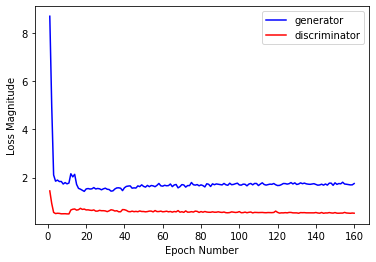

fish in epoch: 160


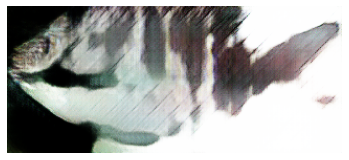

Time for epoch 160 is 81.2058379650116 sec
start epoch 161
epoch: 161 [D real loss: 0.460217] [D fake loss: 0.590135] [D mean loss: 0.525176] [G loss: 1.710649]
Time for epoch 161 is 77.28102803230286 sec
start epoch 162
epoch: 162 [D real loss: 0.466545] [D fake loss: 0.599619] [D mean loss: 0.533082] [G loss: 1.703033]
Time for epoch 162 is 75.2036018371582 sec
start epoch 163
epoch: 163 [D real loss: 0.465110] [D fake loss: 0.596958] [D mean loss: 0.531034] [G loss: 1.744551]
Time for epoch 163 is 75.26972889900208 sec
start epoch 164
epoch: 164 [D real loss: 0.468269] [D fake loss: 0.614267] [D mean loss: 0.541268] [G loss: 1.789359]
Time for epoch 164 is 75.17701077461243 sec
start epoch 165
epoch: 165 [D real loss: 0.454971] [D fake loss: 0.584974] [D mean loss: 0.519972] [G loss: 1.673822]
Time for epoch 165 is 75.26389598846436 sec
start epoch 166
epoch: 166 [D real loss: 0.452514] [D fake loss: 0.590762] [D mean loss: 0.521638] [G loss: 1.724400]
Time for epoch 166 is 75.26030

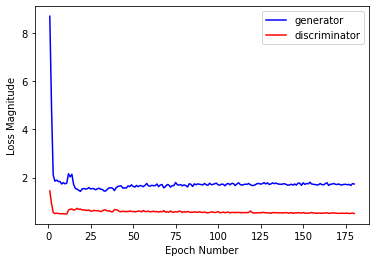

fish in epoch: 180


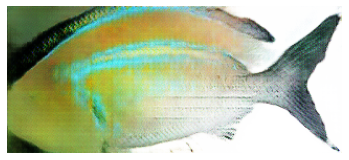

Time for epoch 180 is 81.46911668777466 sec
start epoch 181
epoch: 181 [D real loss: 0.448039] [D fake loss: 0.585784] [D mean loss: 0.516911] [G loss: 1.723652]
Time for epoch 181 is 77.03518533706665 sec
start epoch 182
epoch: 182 [D real loss: 0.446713] [D fake loss: 0.585726] [D mean loss: 0.516220] [G loss: 1.738296]
Time for epoch 182 is 77.07835412025452 sec
start epoch 183
epoch: 183 [D real loss: 0.446000] [D fake loss: 0.582425] [D mean loss: 0.514213] [G loss: 1.725044]
Time for epoch 183 is 77.1381893157959 sec
start epoch 184
epoch: 184 [D real loss: 0.454944] [D fake loss: 0.579925] [D mean loss: 0.517435] [G loss: 1.654357]
Time for epoch 184 is 77.00543522834778 sec
start epoch 185
epoch: 185 [D real loss: 0.443766] [D fake loss: 0.585552] [D mean loss: 0.514659] [G loss: 1.712898]
Time for epoch 185 is 77.14001059532166 sec
start epoch 186
epoch: 186 [D real loss: 0.449071] [D fake loss: 0.584798] [D mean loss: 0.516934] [G loss: 1.737322]
Time for epoch 186 is 77.0361

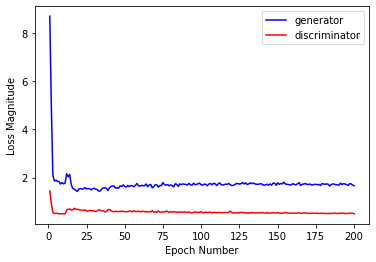

fish in epoch: 200


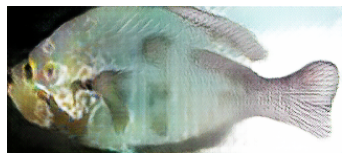

Time for epoch 200 is 79.89069247245789 sec
start epoch 201
epoch: 201 [D real loss: 0.438049] [D fake loss: 0.575741] [D mean loss: 0.506895] [G loss: 1.713417]
Time for epoch 201 is 76.90255928039551 sec
start epoch 202
epoch: 202 [D real loss: 0.439870] [D fake loss: 0.568272] [D mean loss: 0.504071] [G loss: 1.679381]
Time for epoch 202 is 77.00564432144165 sec
start epoch 203
epoch: 203 [D real loss: 0.449178] [D fake loss: 0.588532] [D mean loss: 0.518855] [G loss: 1.725557]
Time for epoch 203 is 77.02414894104004 sec
start epoch 204
epoch: 204 [D real loss: 0.440709] [D fake loss: 0.575374] [D mean loss: 0.508042] [G loss: 1.714006]
Time for epoch 204 is 77.14996910095215 sec
start epoch 205
epoch: 205 [D real loss: 0.438224] [D fake loss: 0.572722] [D mean loss: 0.505473] [G loss: 1.724599]
Time for epoch 205 is 77.0876088142395 sec
start epoch 206
epoch: 206 [D real loss: 0.443026] [D fake loss: 0.575608] [D mean loss: 0.509317] [G loss: 1.731113]
Time for epoch 206 is 77.0230

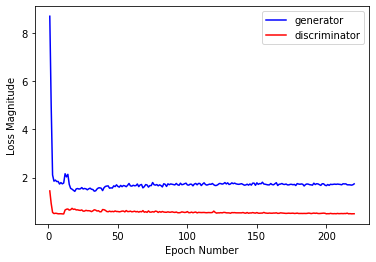

fish in epoch: 220


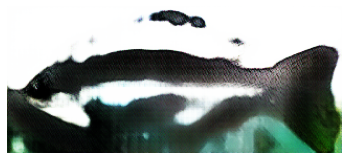

Time for epoch 220 is 80.92928290367126 sec
start epoch 221
epoch: 221 [D real loss: 0.429421] [D fake loss: 0.567213] [D mean loss: 0.498317] [G loss: 1.748030]
Time for epoch 221 is 76.98846077919006 sec
start epoch 222
epoch: 222 [D real loss: 0.436903] [D fake loss: 0.569728] [D mean loss: 0.503316] [G loss: 1.722960]
Time for epoch 222 is 77.03283977508545 sec
start epoch 223
epoch: 223 [D real loss: 0.438019] [D fake loss: 0.576106] [D mean loss: 0.507062] [G loss: 1.755702]
Time for epoch 223 is 77.05371761322021 sec
start epoch 224
epoch: 224 [D real loss: 0.438271] [D fake loss: 0.570549] [D mean loss: 0.504410] [G loss: 1.753801]
Time for epoch 224 is 77.02958965301514 sec
start epoch 225
epoch: 225 [D real loss: 0.436887] [D fake loss: 0.561737] [D mean loss: 0.499312] [G loss: 1.670054]
Time for epoch 225 is 77.0589246749878 sec
start epoch 226
epoch: 226 [D real loss: 0.445497] [D fake loss: 0.565964] [D mean loss: 0.505731] [G loss: 1.713237]
Time for epoch 226 is 76.9665

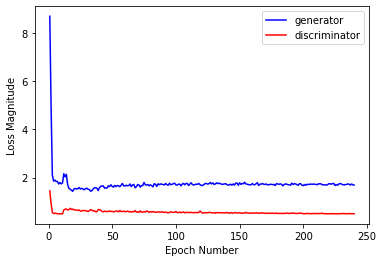

fish in epoch: 240


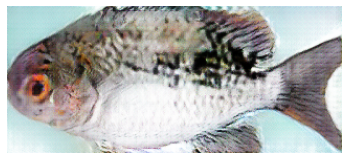

Time for epoch 240 is 79.8014087677002 sec
start epoch 241
epoch: 241 [D real loss: 0.441329] [D fake loss: 0.576274] [D mean loss: 0.508802] [G loss: 1.682533]
Time for epoch 241 is 76.82286477088928 sec
start epoch 242
epoch: 242 [D real loss: 0.436009] [D fake loss: 0.565514] [D mean loss: 0.500762] [G loss: 1.735519]
Time for epoch 242 is 77.03318905830383 sec
start epoch 243
epoch: 243 [D real loss: 0.434193] [D fake loss: 0.568554] [D mean loss: 0.501373] [G loss: 1.677027]
Time for epoch 243 is 76.95605993270874 sec
start epoch 244
epoch: 244 [D real loss: 0.439543] [D fake loss: 0.567837] [D mean loss: 0.503690] [G loss: 1.715766]
Time for epoch 244 is 76.97245740890503 sec
start epoch 245
epoch: 245 [D real loss: 0.425473] [D fake loss: 0.558030] [D mean loss: 0.491751] [G loss: 1.704594]
Time for epoch 245 is 76.98674869537354 sec
start epoch 246
epoch: 246 [D real loss: 0.436095] [D fake loss: 0.568649] [D mean loss: 0.502372] [G loss: 1.729490]
Time for epoch 246 is 76.9387

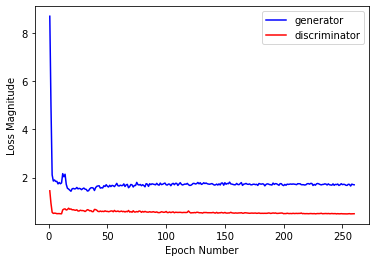

fish in epoch: 260


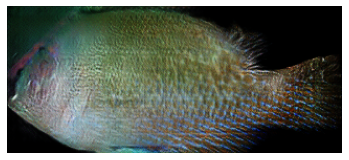

Time for epoch 260 is 81.7943651676178 sec
start epoch 261
epoch: 261 [D real loss: 0.428711] [D fake loss: 0.566227] [D mean loss: 0.497469] [G loss: 1.726878]
Time for epoch 261 is 75.72975397109985 sec
start epoch 262
epoch: 262 [D real loss: 0.428174] [D fake loss: 0.566381] [D mean loss: 0.497278] [G loss: 1.713744]
Time for epoch 262 is 75.24324154853821 sec
start epoch 263
epoch: 263 [D real loss: 0.431234] [D fake loss: 0.556829] [D mean loss: 0.494032] [G loss: 1.655190]
Time for epoch 263 is 75.1233012676239 sec
start epoch 264
epoch: 264 [D real loss: 0.443893] [D fake loss: 0.566508] [D mean loss: 0.505200] [G loss: 1.713209]
Time for epoch 264 is 75.1730887889862 sec
start epoch 265
epoch: 265 [D real loss: 0.424012] [D fake loss: 0.569080] [D mean loss: 0.496546] [G loss: 1.682870]
Time for epoch 265 is 75.19893980026245 sec
start epoch 266
epoch: 266 [D real loss: 0.432367] [D fake loss: 0.566985] [D mean loss: 0.499676] [G loss: 1.745657]
Time for epoch 266 is 75.255693

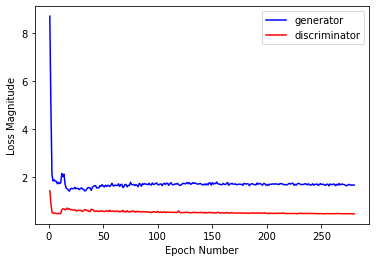

fish in epoch: 280


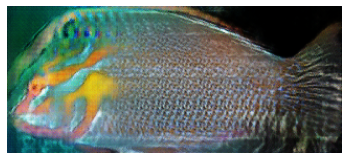

Time for epoch 280 is 80.97356343269348 sec
start epoch 281
epoch: 281 [D real loss: 0.419386] [D fake loss: 0.559847] [D mean loss: 0.489616] [G loss: 1.697758]
Time for epoch 281 is 77.04351949691772 sec
start epoch 282
epoch: 282 [D real loss: 0.433322] [D fake loss: 0.551240] [D mean loss: 0.492281] [G loss: 1.699670]
Time for epoch 282 is 75.48074674606323 sec
start epoch 283
epoch: 283 [D real loss: 0.430042] [D fake loss: 0.554365] [D mean loss: 0.492203] [G loss: 1.662032]
Time for epoch 283 is 76.76700401306152 sec
start epoch 284
epoch: 284 [D real loss: 0.437788] [D fake loss: 0.564164] [D mean loss: 0.500976] [G loss: 1.718580]
Time for epoch 284 is 75.15458607673645 sec
start epoch 285
epoch: 285 [D real loss: 0.437373] [D fake loss: 0.574212] [D mean loss: 0.505792] [G loss: 1.723417]
Time for epoch 285 is 75.33578133583069 sec
start epoch 286
epoch: 286 [D real loss: 0.422307] [D fake loss: 0.547840] [D mean loss: 0.485074] [G loss: 1.698686]
Time for epoch 286 is 74.953

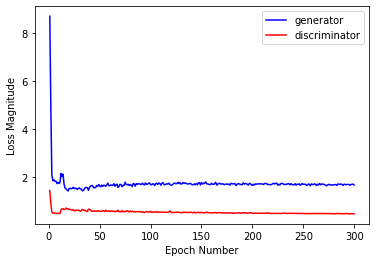

fish in epoch: 300


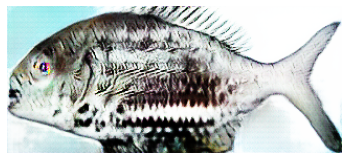

Time for epoch 300 is 81.47842645645142 sec
start epoch 301
epoch: 301 [D real loss: 0.424533] [D fake loss: 0.551720] [D mean loss: 0.488127] [G loss: 1.680960]
Time for epoch 301 is 75.7335205078125 sec
start epoch 302
epoch: 302 [D real loss: 0.427429] [D fake loss: 0.547898] [D mean loss: 0.487663] [G loss: 1.658224]
Time for epoch 302 is 75.08228611946106 sec
start epoch 303
epoch: 303 [D real loss: 0.421181] [D fake loss: 0.551030] [D mean loss: 0.486105] [G loss: 1.681302]
Time for epoch 303 is 75.25772380828857 sec
start epoch 304
epoch: 304 [D real loss: 0.428133] [D fake loss: 0.559439] [D mean loss: 0.493786] [G loss: 1.706566]
Time for epoch 304 is 75.26600432395935 sec
start epoch 305
epoch: 305 [D real loss: 0.433614] [D fake loss: 0.554091] [D mean loss: 0.493853] [G loss: 1.733422]
Time for epoch 305 is 75.30634665489197 sec
start epoch 306
epoch: 306 [D real loss: 0.429140] [D fake loss: 0.560422] [D mean loss: 0.494781] [G loss: 1.739470]
Time for epoch 306 is 75.3597

In [0]:
def sample_image(epoch):
    z = generate_noise(1, NOISE_SIZE)

    Gz = generator(z)[0]
    # Rescale images 0 - 1
    Gz = 0.5 * Gz + 0.5
    f = plt.figure()
    plt.imshow(Gz)
    plt.axis('off')

    if not os.path.exists(sample_imgs_path):
        os.makedirs(sample_imgs_path)
    plt.show()
    f.savefig(sample_imgs_path + '/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()


def save_models(gen, disc, path):
    if not os.path.exists(path):
        os.makedirs(path)
    disc.save(path + disc_save_name)
    gen.save(path + gen_save_name)


def plot_losses(g_loss, d_loss, epoch):
    f = plt.figure()
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss Magnitude')
    plt.plot(list(range(1, len(g_loss) + 1)), g_loss, color='blue', label='generator')
    plt.plot(list(range(1, len(d_loss) + 1)), d_loss, color='red', label='discriminator')
    plt.legend(loc='upper right')
    plt.show()
    f.savefig(graph_path + '/losses_eopch_{:04d}.png'.format(epoch))
    plt.close()


def train(dataset, epochs):
    sample_epoch = 20
    save_epoch = 10

    g_losses_epoch = []
    d_losses_epoch = []
    for epoch in range(epochs):
        print('start epoch {}'.format(epoch + 1))
        start = time.time()
        # shuffle the dataset
        dataset.shuffle(n_images).batch(BATCH_SIZE)
        g_losses = []
        d_real_losses = []
        d_fake_losses = []

        for i, image_batch in enumerate(dataset):
            d_real_loss, d_fake_loss, g_loss = train_step(image_batch)

            d_real_losses.append(np.mean(d_real_loss))
            d_fake_losses.append(np.mean(d_fake_loss))
            g_losses.append(np.mean(g_loss))

        epoch_g_loss = np.float(np.mean(g_losses))
        epoch_d_real_loss = np.float(np.mean(d_real_losses))
        epoch_d_fake_loss = np.float(np.mean(d_fake_losses))
        epoch_d_loss = (epoch_d_real_loss + epoch_d_fake_loss) / 2
        print('epoch: %d [D real loss: %f] [D fake loss: %f] [D mean loss: %f] [G loss: %f]' % (
            epoch + 1, epoch_d_real_loss, epoch_d_fake_loss, epoch_d_loss,
            epoch_g_loss))
        g_losses_epoch.append(epoch_g_loss)
        d_losses_epoch.append(epoch_d_loss)
        if (epoch + 1) % save_epoch == 0:
            save_models(generator, discriminator, models_save_path)
            print('saved models in epoch: {}'.format(epoch + 1))
        if (epoch + 1) % sample_epoch == 0:
            plot_losses(g_losses_epoch, d_losses_epoch, epoch + 1)
            print('fish in epoch: {}'.format(epoch + 1))
            sample_image(epoch + 1)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))


train(dataset, EPOCHS)
